## ThinkDSP

This notebook contains

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

PI2 = np.pi * 2

%matplotlib inline

### Do we hear phase?

This notebook investigates what effect, if any, changes in phase have on our perception of sound.

I'll start with a simple waveform, a sawtooth, and move on to more natural sounds.

In [2]:
signal = thinkdsp.SawtoothSignal(freq=500, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.make_audio()

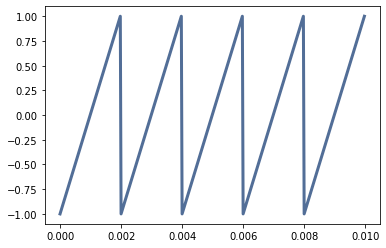

In [3]:
wave.segment(duration=0.01).plot()

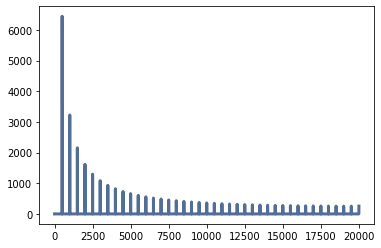

In [4]:
spectrum = wave.make_spectrum()
spectrum.plot()

The following function plots the angle part of the spectrum.

In [5]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    thinkplot.plot(spectrum.fs, angles, style='x')
    thinkplot.config(xlim=[0, spectrum.max_freq],
                     ylim =[-np.pi, np.pi])

At most frequencies, the amplitude is small and the angle is pretty much a random number.  So if we plot all of the angles, it's a bit of a mess.

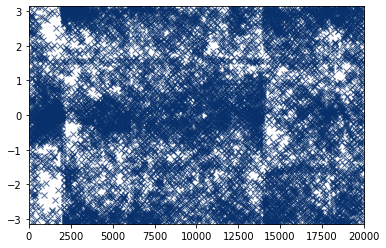

In [6]:
plot_angle(spectrum, thresh=0)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

But if we select only the frequencies where the magnitude exceeds a threshold, we see that there is a structure in the angles.  Each harmonic is offset from the previous one by a fraction of a radian.

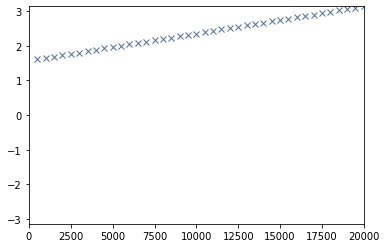

In [7]:
plot_angle(spectrum, thresh=1)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

The following function plots the amplitudes, angles, and waveform for a given spectrum. 

In [8]:
def plot_three(spectrum, thresh=1):
    thinkplot.preplot(cols=3)
    spectrum.plot()
    thinkplot.subplot(2)
    plot_angle(spectrum, thresh=thresh)
    thinkplot.subplot(3)
    wave = spectrum.make_wave()
    wave.segment(duration=0.01).plot()
    wave.apodize()
    display(wave.make_audio())

So we can visualize the unmodified spectrum:

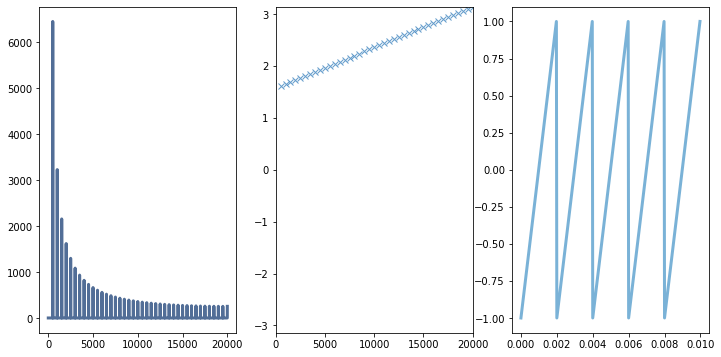

In [9]:
plot_three(spectrum)

Now let's see what happens if we set all the angles to zero.

In [10]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

The amplitudes are unchanged, the angles are all zero, and the waveform looks very different.  But the wave sounds pretty much the same; to me, the only change is that the volume seems lower.

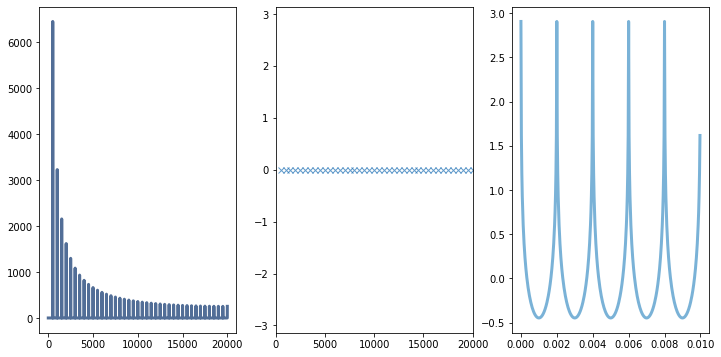

In [11]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

If we multiply the complex components by $\exp(i\phi)$, it has the effect of adding $\phi$ to the angles:

In [12]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

We can see the effect in the figure below.  Again, the wave form is different, but it sounds pretty much the same.

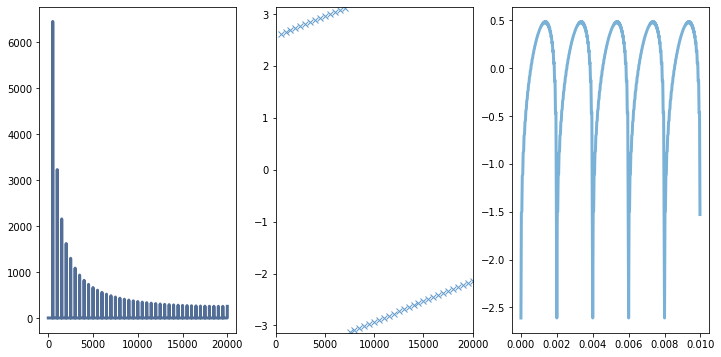

In [13]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

So let's see what happens if we set the angles to random values.

In [14]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

The effect on the waveform is profound, but the perceived sound is the same.

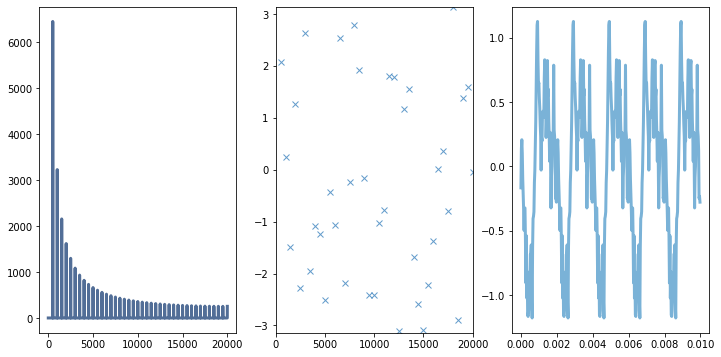

In [15]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

### Oboe

With more natural sounds, the results are somewhat different.  Here's recording of an oboe.

In [16]:
wave = thinkdsp.read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

I'll select a segment where the pitch is constant.

In [17]:
segment = wave.segment(start=0.05, duration=0.6)

Here's what the original looks like.

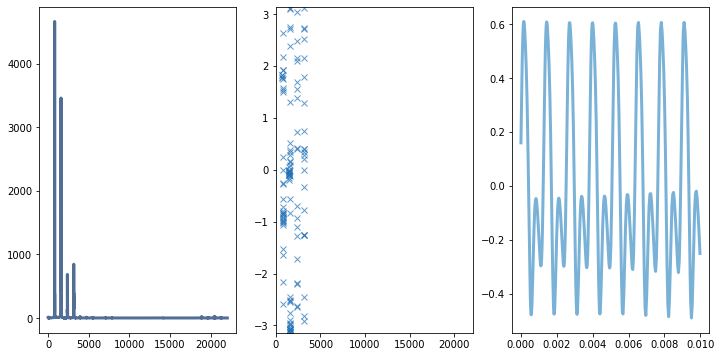

In [18]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Here it is with all angles set to zero.

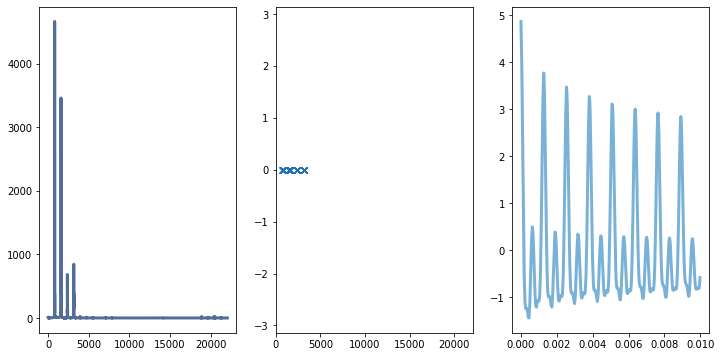

In [19]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Here it is with the angles rotated by 1 radian.

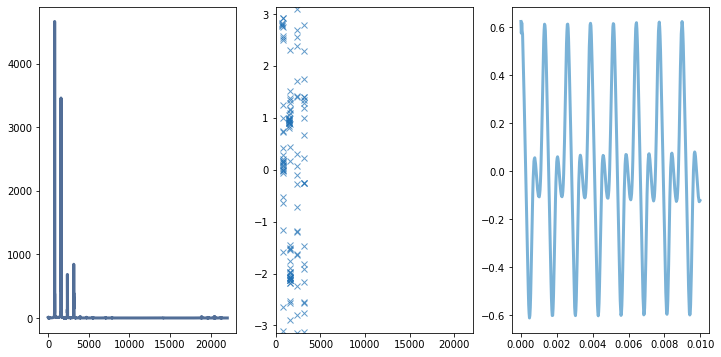

In [20]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

And here it is with randomized angles.

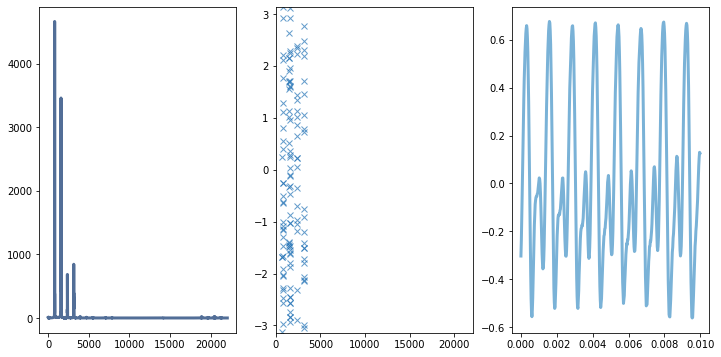

In [21]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

To my ear, setting the angles to zero seem to turn down the volume, rotating the angles has no effect, and randomizing the angles gives the sound a hint of an etherial quality.

### Saxophone

Let's try the same thing with a segment from a recording of a saxophone.

In [22]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()
segment = wave.segment(start=1.9, duration=0.6)

The original:

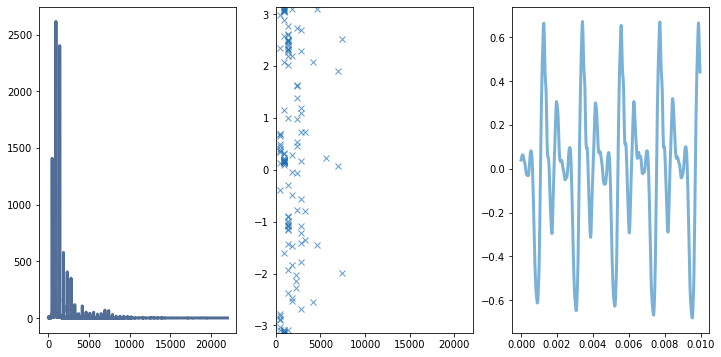

In [23]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Set angles to 0.

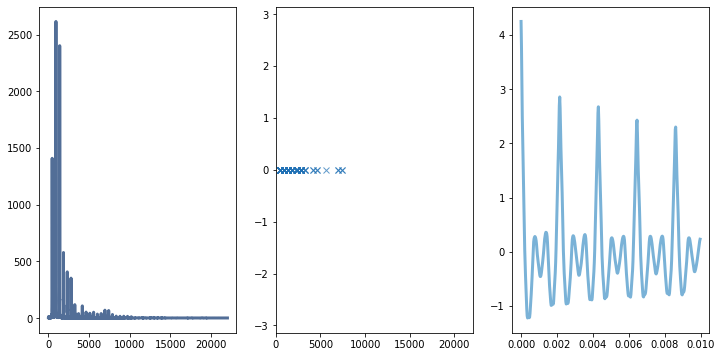

In [24]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Rotate angles by 1 radian.

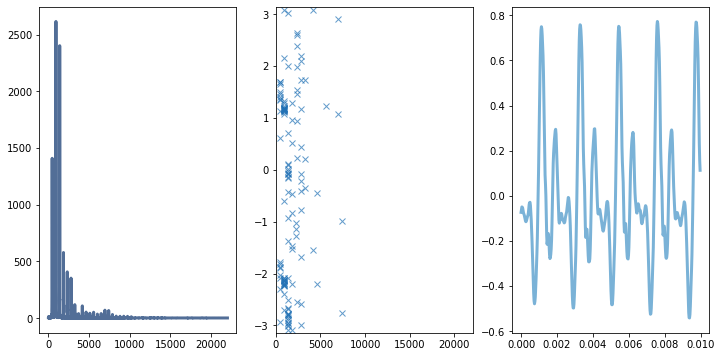

In [25]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Randomize the angles.

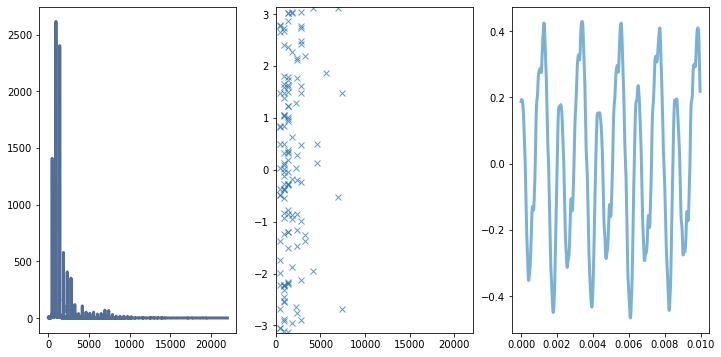

In [26]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Again, zeroing seems to mute the volume, rotating has no effect, and randomizing adds some kind of effect, in this case something like a reverb.

One way the saxophone differs from the other sounds is that the fundamental component is not dominant.  For sounds like that, I conjecture that the ear uses something like autocorrelation in addition to spectral analysis, and it's possible that this secondary mode of analysis is more sensitive to phase structure.

If so, the effect should be more profound when the fundamental is missing altogether.


### Saxophone with missing fundamental

Let's run these steps one more time after filtering out the fundamental.

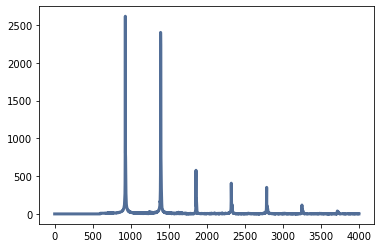

In [27]:
spectrum.high_pass(600)
spectrum.plot(high=4000)

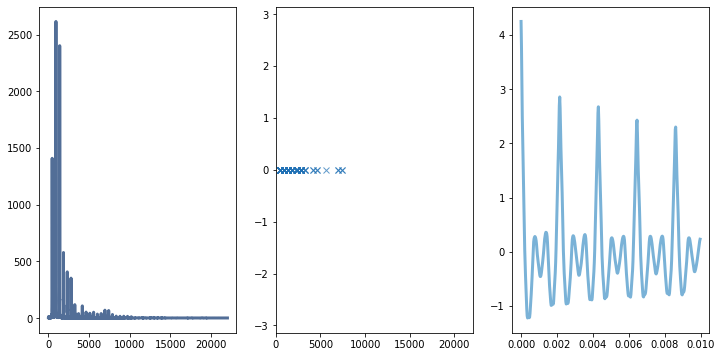

In [28]:
plot_three(spectrum2, thresh=50)

Zeroing

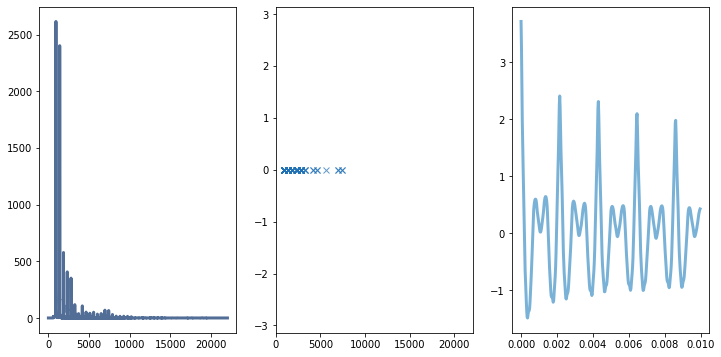

In [29]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Rotating

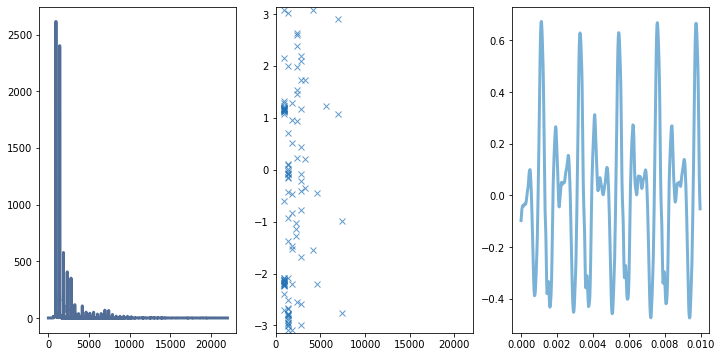

In [30]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Randomizing

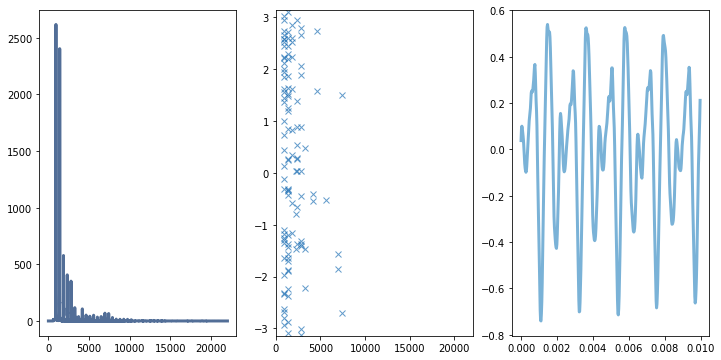

In [31]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

For this segment, changing the phase structure has an audible effect, especially randomizing.

If the ear uses something like autocorrelation to analyze sounds like this, we might expect to see changes in the autocorrelation function when we change the phase structure.

The following functions plot the ACF for these segments:

In [32]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

In [33]:
def plot_acf(spectrum):
    corrs = autocorr(spectrum.make_wave())
    thinkplot.plot(corrs[:200], linewidth=1)

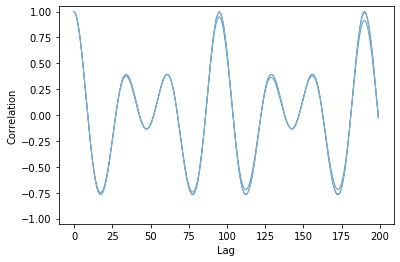

In [34]:
plot_acf(spectrum)
plot_acf(spectrum2)
plot_acf(spectrum3)
plot_acf(spectrum4)
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

Changing the phase structure has some effect on the ACF, but not much, and there's nothing there that obviously explains the changes in the perceived sound.

In summary:

1.  At least for sounds like this that have simple harmonic structure, it seems like we are mostly "phase blind"; that is, we don't hear changes in the phase structure, provided that the harmonic structure is unchanged.

2.  A possible exception is sounds with low amplitude at the fundamental frequecy.  In that case we use something autocorrelation-like to perceive pitch, and there a hint that this analysis might be more sensitive to the phase structure.

3.  However, there is nothing obvious in the ACF that explains the effect.